# **R implementation of Bayesian Blocks algorithm**

*Gaudio Raffaele* (2057974)

### Abstract

Data visualization is one of the main problems in data analysis. The Bayesian Block algorithm is a useful tool for improving the binning of histograms by finding the optimal segmentation of the data.
Furthermore, it allows us to discover local structures in background data, exploiting the full information brought by the data.
The main objective of this project is to implement the Bayesian Block algorithm in R and test it with different datasets.

--------------------------------------

## 1. The idea of the algorithm

The Bayesian Blocks algorithm is a nonparametric modeling technique for determining the optimal segmentation of a given set of univariate random variables. Each **block** (or bin, in the context of histograms) is consistent with a pdf with compact support; the entire dataset is represented by this collection of finite pdfs. 

The number of blocks and the edges of the blocks are determined through optimization of a **fitness function**, which is essentially a
goodness-of-fit statistic dependent only on the input data and a regularization parameter.

The set of blocks is gapless and non-overlapping, where the first block edge is defined by the first data point, and the last block edge is defined by the last data-point. A block can contain between $1$ and $N$ data points, where the sum of the contents of all the blocks must equal $N$.

The algorithm relies on the additivity of the fitness function, thus the fitness of a given set of blocks is equal to the sum of the fitness of the individual blocks.

Given an ordered set of $N$ data points, the algorithm determines the optimal set of $k + 1$ change-points (and therefore $k$ blocks) by iterating through the data-points, and catching the current maximum fitness values and corresponding indices. 

## 2. The bayesian framework

Before defining our mathematical framework, let's examine what characteristics we would like our algorithm to have:

* Non-parametric: generic representation of data (not fitting). 

* Discover local structures in background data exploiting the full information brought
by the data.

* Impose as few preconditions as possible on signal and background shapes.

* Handle arbitrary sampling and dynamic ranges of data.

* Operate in a bayesian framework and work with posterior probabilities:

$$
P(M|D) ∝ P(D|M)P(M)
$$






### 2.1. The Piecewise Constant Model

The range of the independent variable (e.g. time) is divided into subintervals (called **blocks**) generally unequal in size, in which the dependent variable (e.g. intensity) is modeled as constant within errors. Of all possible said “step functions” this approach yields
the best one by maximizing some goodness-of-fit measure.

Defining the times ending one block and starting the next as change-points, the model of the whole observation interval contains these parameters:

* $N_{cp}$: the number of change-points,

* $t^{cp}_k$: the change-point starting block $k$ (and ending block $k − 1$),

* $X_k$: the signal amplitude in block $k$

for $k=1,2,..., N_{cp}+1$. There is one more block than there are change-points: The first datum is always considered a change-point, marking the start of the first block, and is therefore not a free parameter. If the last datum is a change-point, it denotes a block consisting solely of that datum.

The key idea is that the blocks can be treated independently, in the sense that a block’s fitness depends on its data only. Our model for each block has effectively two parameters. The first represents the **signal amplitude**, and is treated as a nuisance parameter to be determined after the change-points have been located. The second parameter is the **length** of the interval spanned by the block.

### 2.2. Fitness function $P(D|M)$ - Cash statistics

As indicated previously, the algorithm relies on the fitness being block-additive:

$$
F_{total}=\sum_{k=1} ^{N_{blocks}} f(B_k) 
$$

where $F_{total}$ is the total fitness of the partition for a given dataset and $f(B_k)$ is the fitness of the k-th block. Our best model is the one that maximizes $F_{total}$ over all possible partitions.

There is a considerable freedom in choosing the fitness function. For this implementation **Cash statistics** has been used (Cash 1979). With a model $M(t,θ)$, the unbinned log-likelihood reads:

$$
\log L(\theta)=\sum_n \log M(t_n , \theta)- \int M(t,\theta)dt
$$

where the sum is over the data and $θ$ represents the model parameters.

Our block model is constant with a single parameter, $M(t,\lambda)=\lambda$, where $\lambda$ is the height of the block (the nusiance parameter). Therefore, for block $k$:

$$
\log L^{(k)}(\lambda)=N^{(k)}\log\lambda -\lambda T^{(k)}
$$

where $N^{(k)}$ is the number of events in block $k$ and $T^{(k)}$ is the length of the block.

Now we maximize with respect to the nuisance parameter $λ$:

\begin{align*}
\log L^{(k)}_{max} &=  N^{(k)}(\log N^{(k)}-\log T^{(k)})+N^{(k)} \\
&= N^{(k)}(\log N^{(k)}-\log T^{(k)})
\end{align*}

where in the second expression the $N^{(k)}$ term sums up to $N$ so it can be dropped because it’s independent of the partition.
We notice that such fitness function has two nice features:
- it is simple

- it is scale invariant ($T \rightarrow \alpha T$)

The fitness of the entire partition will then be :

$$
\log L = \sum_k \log L^{(k)}_{max}
$$


### 2.3. Prior for the number of blocks $P(M)$

We are interested in a representation where $N_{blocks} \ll N$ rather than $N_{blocks} \approx N$, therefore, a flat prior on the number of blocks looks unreasonable.

It is desirable to impose a prior that assigns smaller probability to a large number of blocks. For this reason we select two candidate priors for the algorithm:

* Geometric prior

* Calibrated prior

#### 2.3.1. Geometric prior
The geometric prior is defined as:

$$
P(N_{blocks})= \begin{cases} P_0 \gamma ^{N_{blocks}} & 0 \le N_{blocks} \le N \\
                             0 & \text{otherwise} \end{cases}
$$

$$
P_0=\frac{1-\gamma}{1-\gamma^{N+1}}
$$
where $\gamma$ is a free parameter and $P_0$ is the normalization constant.

This prior must be tuned in order to achieve a reasonable binning for a given dataset. An overly conservative value will suppress the detection of true change-points, while too liberal a value will lead to spurious change-points (eventually reaching the limit of
$N_{blocks} = N$). For $\gamma < 1$, $N$ blocks are favored over $N + 1$ blocks. The prior
can be interpreted as a control on the false-positive rate for detecting change-points.


#### 2.3.2. Calibrated prior

Another approach is to calibrate the prior as a function of the number of data points $N$ and
the false-positive rate $p_0$ on toy pure-noise experiments. A calibration of this type performed in [1] yields:

$$
\log P(N,p_0)= \log(73.53 p_0 N^{-0.478})-4
$$

where

$$
p_0=1-(\text{false positive probability})
$$

is the correct detection rate for individual change-points and represents the frequency with which the algorithm correctly rejects the presence of a change-point in pure noise.

## 3. Implementation

In this section the R implemented function for the Bayesian Block algorithm is presented. The code is built on top of the original one proposed by Luigi Pertoldi written in Julia. [4].

In [1]:
# commodity  cell

library('plyr')

set.seed(42) # "the answer to life, the universe and everything"
options(repr.plot.width=18, repr.plot.height=8)

In [2]:
bayesian.blocks<-function(data,data_type='array',prior='p0',gamma=0.01,p0=0.01,verbose=FALSE){
    
    # -----------------------------------------------------------------
    # Function that implements Bayesian Blocks algorithm in R usig Cash 
    # statistics as fitness function.
    # -----------------------------------------------------------------
    #
    # Params:
    # -------
    # data: numeric, data to be partitioned
    #
    # data_type: string, type of input data
    #           - 'arry': list of data (default)
    #           - 'hist': histogramm of data
    #
    # prior: string, prior distribution 
    #        - 'geometric': gamma prior
    #        - 'p0'       : calibrated prior (default)
    #
    # gamma: double, slope of the prior (default gamma=0.01)
    #
    # p0: double, correct detection rate parameter (default p0=0.01)
    #
    # verbose: bool, if set TRUE prints: prior parameter value, 
    #          number of blocks and computational time (default FALSE)
    #
    # Return:
    # -------
    # bins: vector, N+1 bin edges
    #
    # -----------------------------------------------------------------

    if(verbose){
        tic<-Sys.time()
    }

    if(data_type=='array'){
            require(plyr)
            x_sorted<-sort(data)
            x_unique<-unique(x_sorted)          # not consider repeated data
            x_weight<-count(x_sorted)$freq     
    }
  
    else if(data_type=='hist'){
            br<-data$breaks
            x_unique<-c(br[1],data$mids,br[length(br)])
            x_weight<-c(1,data$counts,1)
    }
    else{
        stop('\n\n ERROR: Invalid input type. \n\n Valid input type are: \n * array \n * hist \n\n' )
    }
    
    # ------------------------------------------------------------------------
    x <- x_unique
    N <- length(x)

    edges<-c(x[1], 0.5*(x[2:N] + x[1:(N-1)]), x[N])
    block_length<-x[N]-edges
    
    best<-matrix(0,nrow=1,ncol=N)
    last<-matrix(0,nrow=1,ncol=N)    
    
    # log-fitness function (cash statistic)
    log_fitness<-function(N_k,T_k){
                return(N_k * (log(N_k) - log(T_k)))
    } 
              
    # log-prior distributions 
    log_prior<-function(string){     
              if(string=='geometric'){
                  return(-log(gamma))
              }
              else if(string=='p0'){
                  return(4 - log(73.53 * p0 * N^(-0.478)))
              }
              else{
                  stop('\n\n ERROR: Invalid prior selected. \n\n Valid priors are: \n * geometric \n * p0 \n\n')
              }
    }
    
    # evaluate the prior on the number of blocks
    ncp_prior<-log_prior(string=prior)
    
    # ------------------------------------------------------------------------
    for(K in 1:N){
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width<-block_length[1:K]-block_length[K+1]
        count_vec<-sort(cumsum(x_weight[1:K]),decreasing=T)   
        
        # evaluate fitness function for these possibilities
        fit_vec<-log_fitness(N_k=count_vec,T_k=width) 
        fit_vec<-fit_vec - ncp_prior     
        fit_vec[2:K]<-fit_vec[2:K]+best[1:(K-1)]

        # max of the fitness
        i_max<-which.max(fit_vec)
    
        last[K]<-i_max
        best[K]<-fit_vec[i_max]      
        }
    
    # ------------------------------------------------------------------------
    change_points<-matrix(0,nrow=1,ncol=N)
    i_cp<-N+1
    ind<-N+1
    
    while(TRUE){
        i_cp<-i_cp-1 
        change_points[i_cp]<-ind 
        
        if(ind==1){
            break 
            }
        ind<-last[ind-1]        
    }
    
    change_points<-change_points[(i_cp):N]

    if(verbose){
        toc<-Sys.time()
        time<-as.numeric(toc-tic)

        if(prior=='geometric'){
            cat('----------------------------------------------------------------\n') 
            cat('** Geometric Prior ** \n') 
            cat('Gamma:',gamma, '\n') 
            cat('Number of blocks:', length(edges[change_points])-1,'\n')
            cat('Computational time:',time,'[s]\n') 
            cat('----------------------------------------------------------------\n\n')
        }
        else{
            cat('----------------------------------------------------------------\n') 
            cat('** Calibrated Prior ** \n') 
            cat('p0:',p0, '\n') 
            cat('Number of blocks:', length(edges[change_points])-1,'\n')
            cat('Computational time:',time,'[s]\n') 
            cat('----------------------------------------------------------------\n\n')
        }
    }

    return(edges[change_points])
}

## 4. Applications

In this section we will explore three applications for the Bayesian Blocks algorithm:

* binning of histograms (4.1.)

* peak detector for noisy signals (4.2.)

* kernel density estimator (4.3.).

### 4.1. Binning of histograms

The first application for the algorithm is the binning of histograms. In order to test this application, 1500 random toy data have been generated from a mixture of four normal distributions.

Dimension of dataset: 15000 
Number of bins: 122

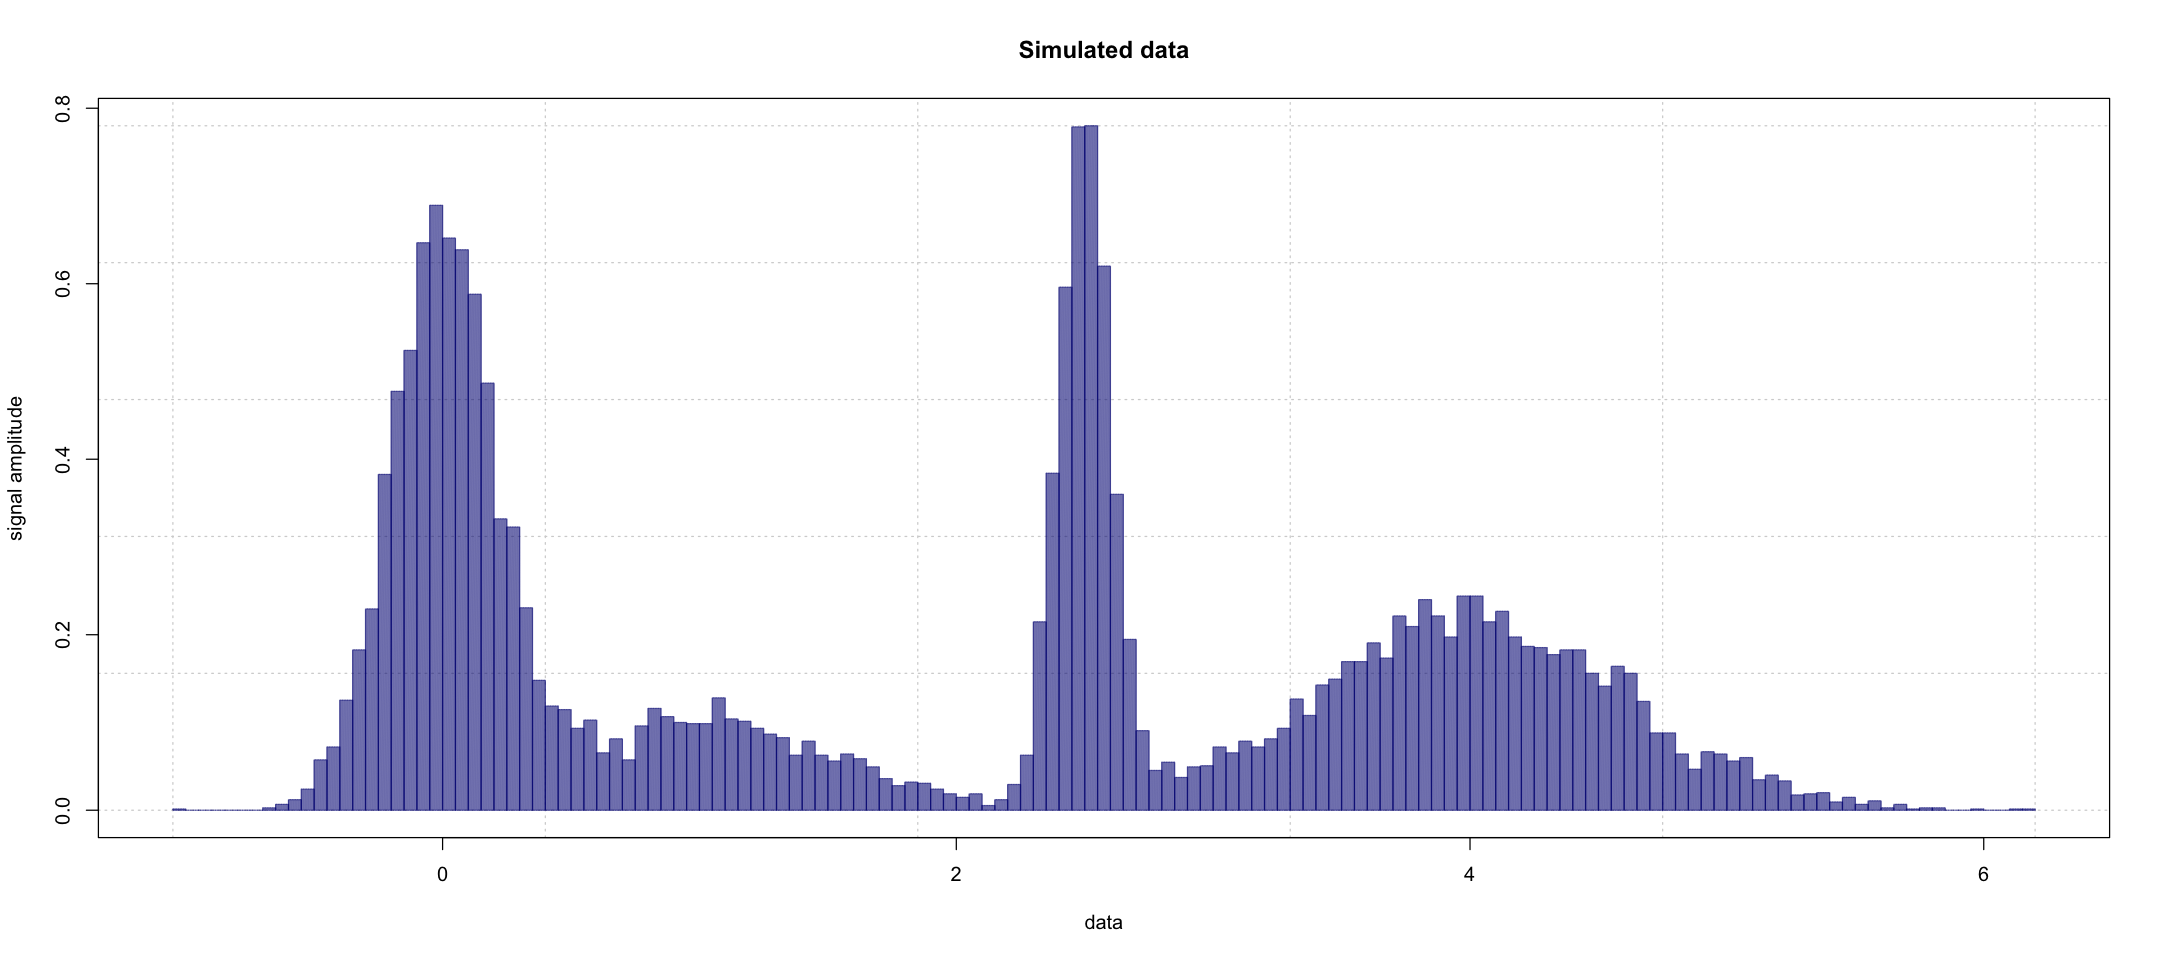

In [3]:
par(bg="white")

data<-c(rnorm(5000,0,0.2),rnorm(2000,1,0.5),rnorm(3000,2.5,0.1),rnorm(5000,4,0.6))
N<-length(data)

cat('Dimension of dataset:',N,'\n')
cat('Number of bins:', as.integer(sqrt(N)))

options(repr.plot.width=18, repr.plot.height=8)

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='signal amplitude',main='Simulated data')

box()

----------------------------------------------------------------
** Geometric Prior ** 
Gamma: 9e-04 
Number of blocks: 34 
Computational time: 5.634704 [s]
----------------------------------------------------------------

----------------------------------------------------------------
** Calibrated Prior ** 
p0: 0.01 
Number of blocks: 29 
Computational time: 5.960671 [s]
----------------------------------------------------------------



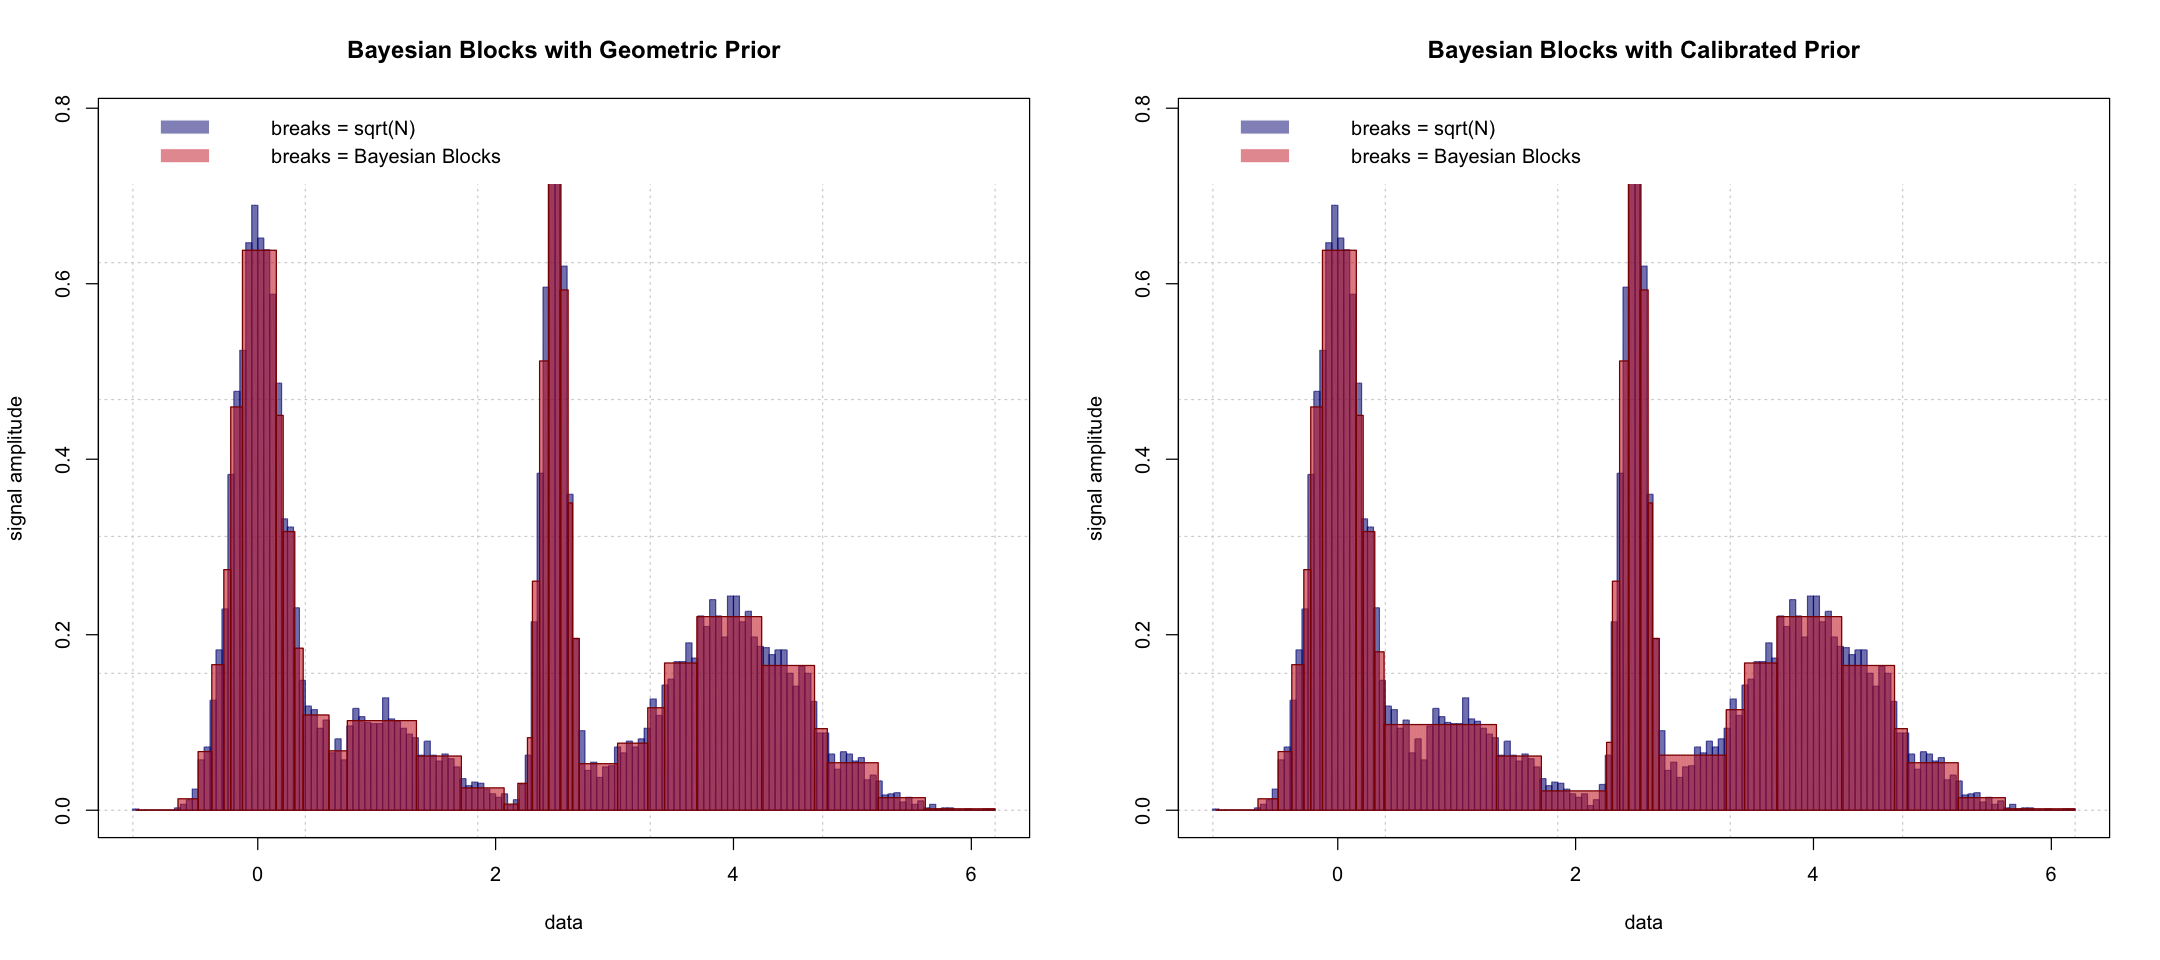

In [4]:
par(mfrow=c(1,2),bg="white")

#--------------------------------------------------------------------
## Geometric Prior ##

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='signal amplitude',main='Bayesian Blocks with Geometric Prior')


breaks<-bayesian.blocks(data,prior='geometric',gamma=0.0009,verbose=T) 

hist(data,breaks=breaks,density=200,
     freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',add=T)

legend('topleft',c('breaks = sqrt(N)','breaks = Bayesian Blocks'), 
       fill=c(scales::alpha('navy',0.5),scales::alpha('firebrick3',0.5)),box.lty=0,border=F) 

box()

#--------------------------------------------------------------------
## Calibrated Prior ##

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='signal amplitude',main='Bayesian Blocks with Calibrated Prior')

breaks<-bayesian.blocks(data,prior='p0',p0=0.01,verbose=T)

hist(data,breaks=breaks,density=200,
     freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',add=T)

legend('topleft',c('breaks = sqrt(N)','breaks = Bayesian Blocks'),
       fill=c(scales::alpha('navy',0.5),scales::alpha('firebrick3',0.5)),box.lty=0,border=F) 

box()


As we can observe, the Bayesian Blocks algorithm brings out a clear representation of the main features of the dataset. Futhermore, we notice that, after a proper tuning of the parameters, the geometric and the calibrated prior both produce a very similar segmentation of the data. 

### 4.2. Signal detection

In this paragraph we test the algorithm as signal detector for noisy data. For this purpose, we generated a uniform background noise and two gaussian signals, one quite sharp ($\mathcal{N}(5,0.01)$) and the other more wide ($\mathcal{N}(7,0.6)$). We would like to observe if the algorithm is able to detect both of the signals.

Dimension of dataset: 23000 
Number of bins: 151

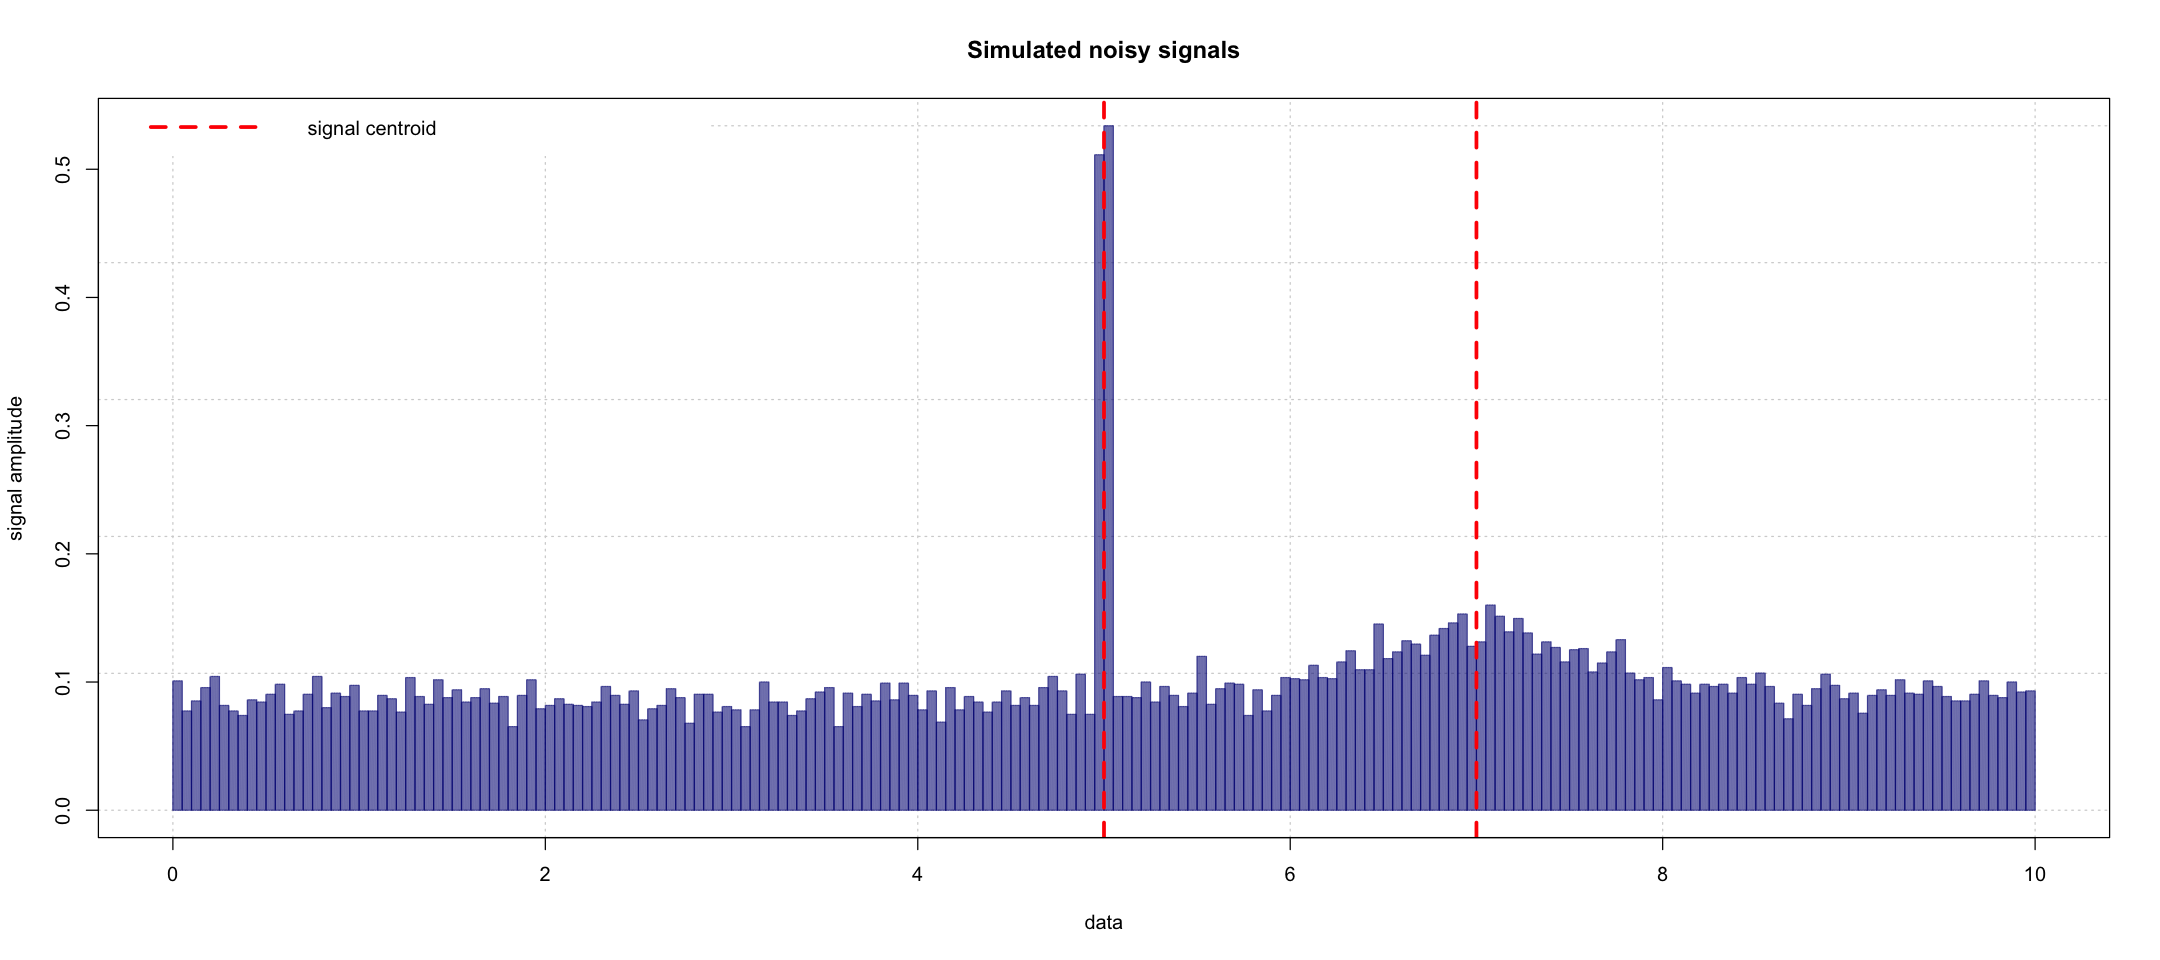

In [5]:
par(bg="white")

noise<-runif(2e4,0,10)

data<-c(noise,rnorm(1e3,5,0.01),rnorm(2e3,7,0.6))
N<-length(data)

cat('Dimension of dataset:',N,'\n')
cat('Number of bins:', as.integer(sqrt(N)))

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='signal amplitude',main='Simulated noisy signals')
abline(v=5, lwd=3, col='red', lty='dashed')
abline(v=7, lwd=3, col='red', lty='dashed')

legend('topleft',legend='signal centroid',
       col='red', lwd=3 ,lty='dashed',box.lty=0,border=F) 

box()

----------------------------------------------------------------
** Geometric Prior ** 
Gamma: 0.001 
Number of blocks: 11 
Computational time: 13.88464 [s]
----------------------------------------------------------------

----------------------------------------------------------------
** Calibrated Prior ** 
p0: 0.001 
Number of blocks: 9 
Computational time: 14.75417 [s]
----------------------------------------------------------------



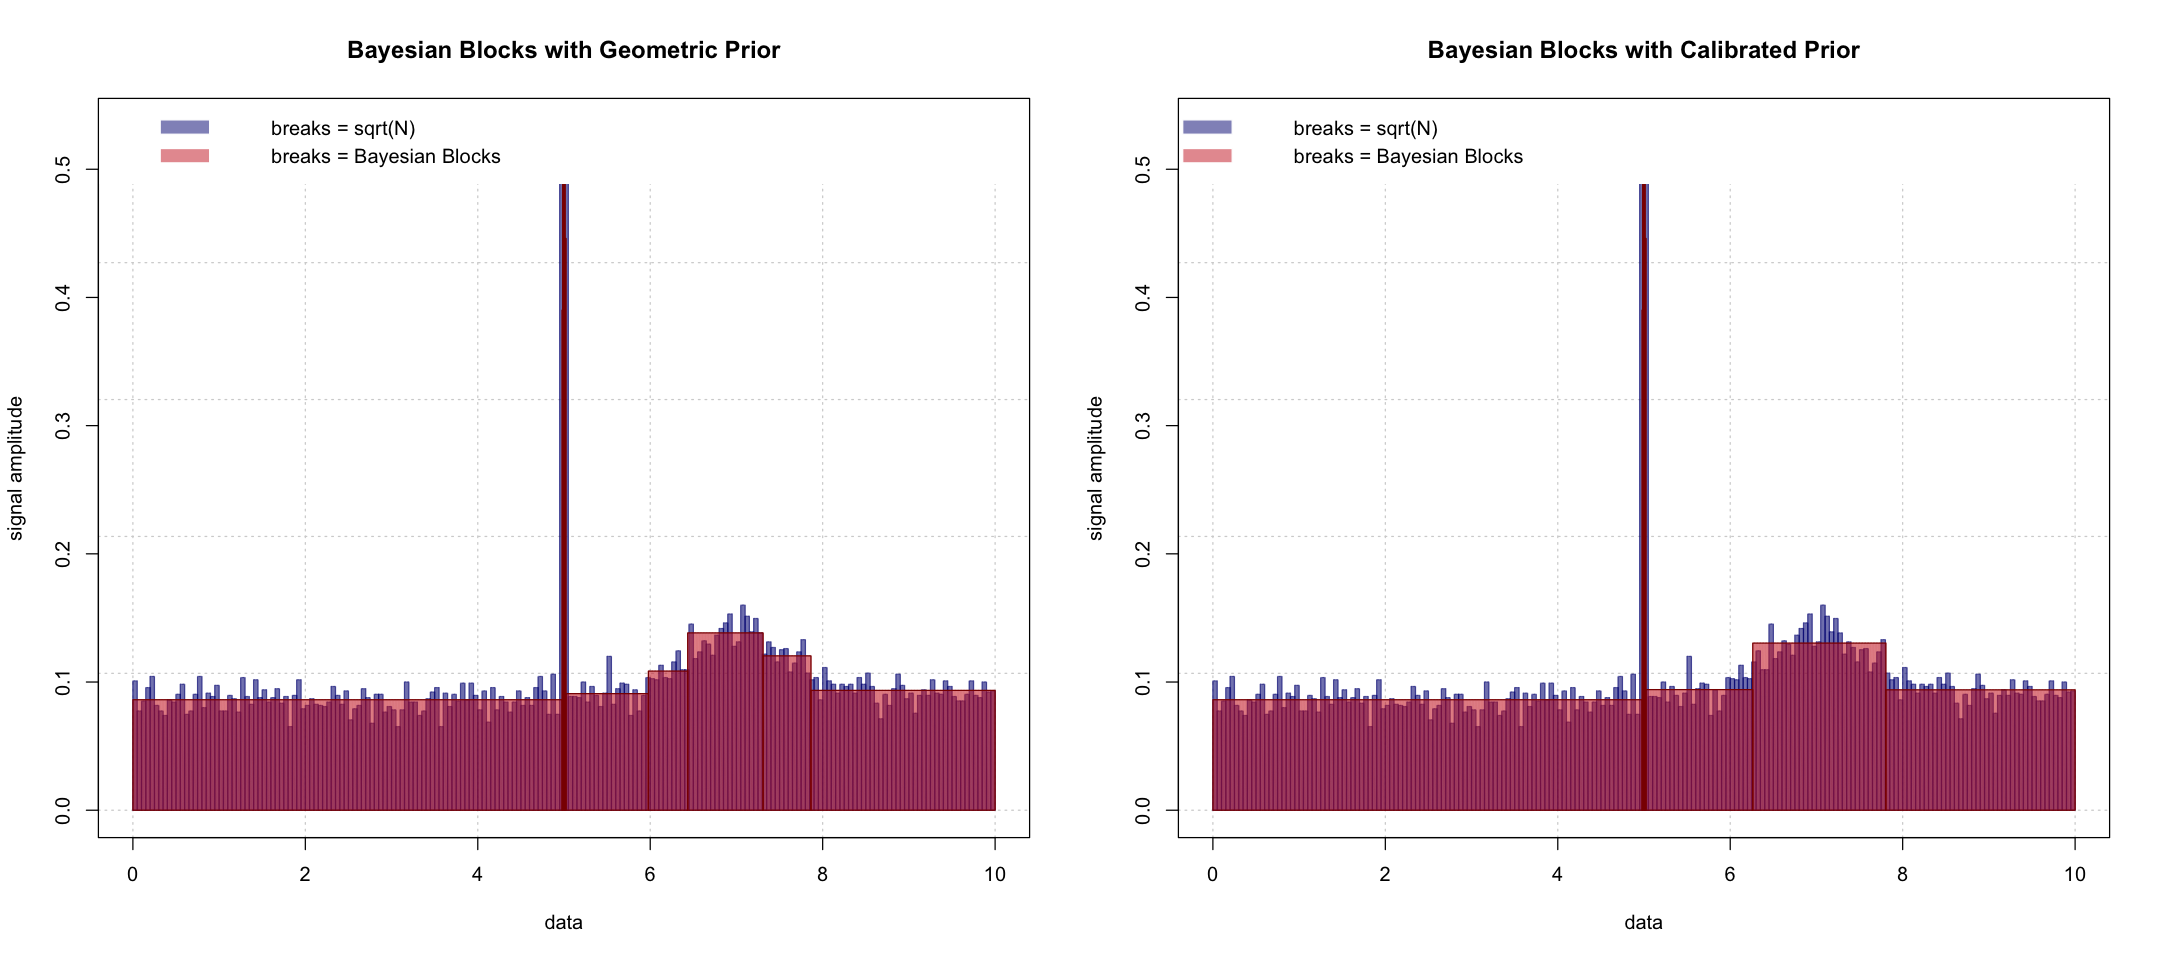

In [6]:
par(mfrow=c(1,2),bg="white")

#--------------------------------------------------------------------
## Geometric Prior ##

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='signal amplitude',main='Bayesian Blocks with Geometric Prior')

breaks<-bayesian.blocks(data,prior='geometric',gamma=0.001,verbose=T)

h1<-hist(data,breaks=breaks,density=200,
          freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',add=T)

legend('topleft',c('breaks = sqrt(N)','breaks = Bayesian Blocks'), 
       fill=c(scales::alpha('navy',0.5),scales::alpha('firebrick3',0.5)),box.lty=0,border=F) 

box()

#--------------------------------------------------------------------
## Calibrated Prior ##

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='signal amplitude',main='Bayesian Blocks with Calibrated Prior')

breaks<-bayesian.blocks(data,prior='p0',p0=0.001,verbose=T)

h2<-hist(data,breaks=breaks,density=200,
          freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',add=T)

legend('topright',c('breaks = sqrt(N)','breaks = Bayesian Blocks'), 
       fill=c(scales::alpha('navy',0.5),scales::alpha('firebrick3',0.5)),box.lty=0,border=F) 

box()


The algorithm is able to distinguish both of the signals from the noisy background. Information on the single block can be easily inspected using the usual syntax for R histograms. By way of example, such information is reported as data frame for the histogram obtained via Calibrated Prior.

block,counts,density,centroid
<int>,<int>,<dbl>,<dbl>
1,9865,0.08618566,2.489321
2,54,0.39008075,4.980639
3,201,0.94778926,4.988259
4,572,1.72327884,5.000085
5,157,1.04286187,5.010573
6,105,0.44602715,5.018964
7,2678,0.09408264,5.642871
8,4628,0.13036286,7.033420
9,4740,0.09390715,8.902470


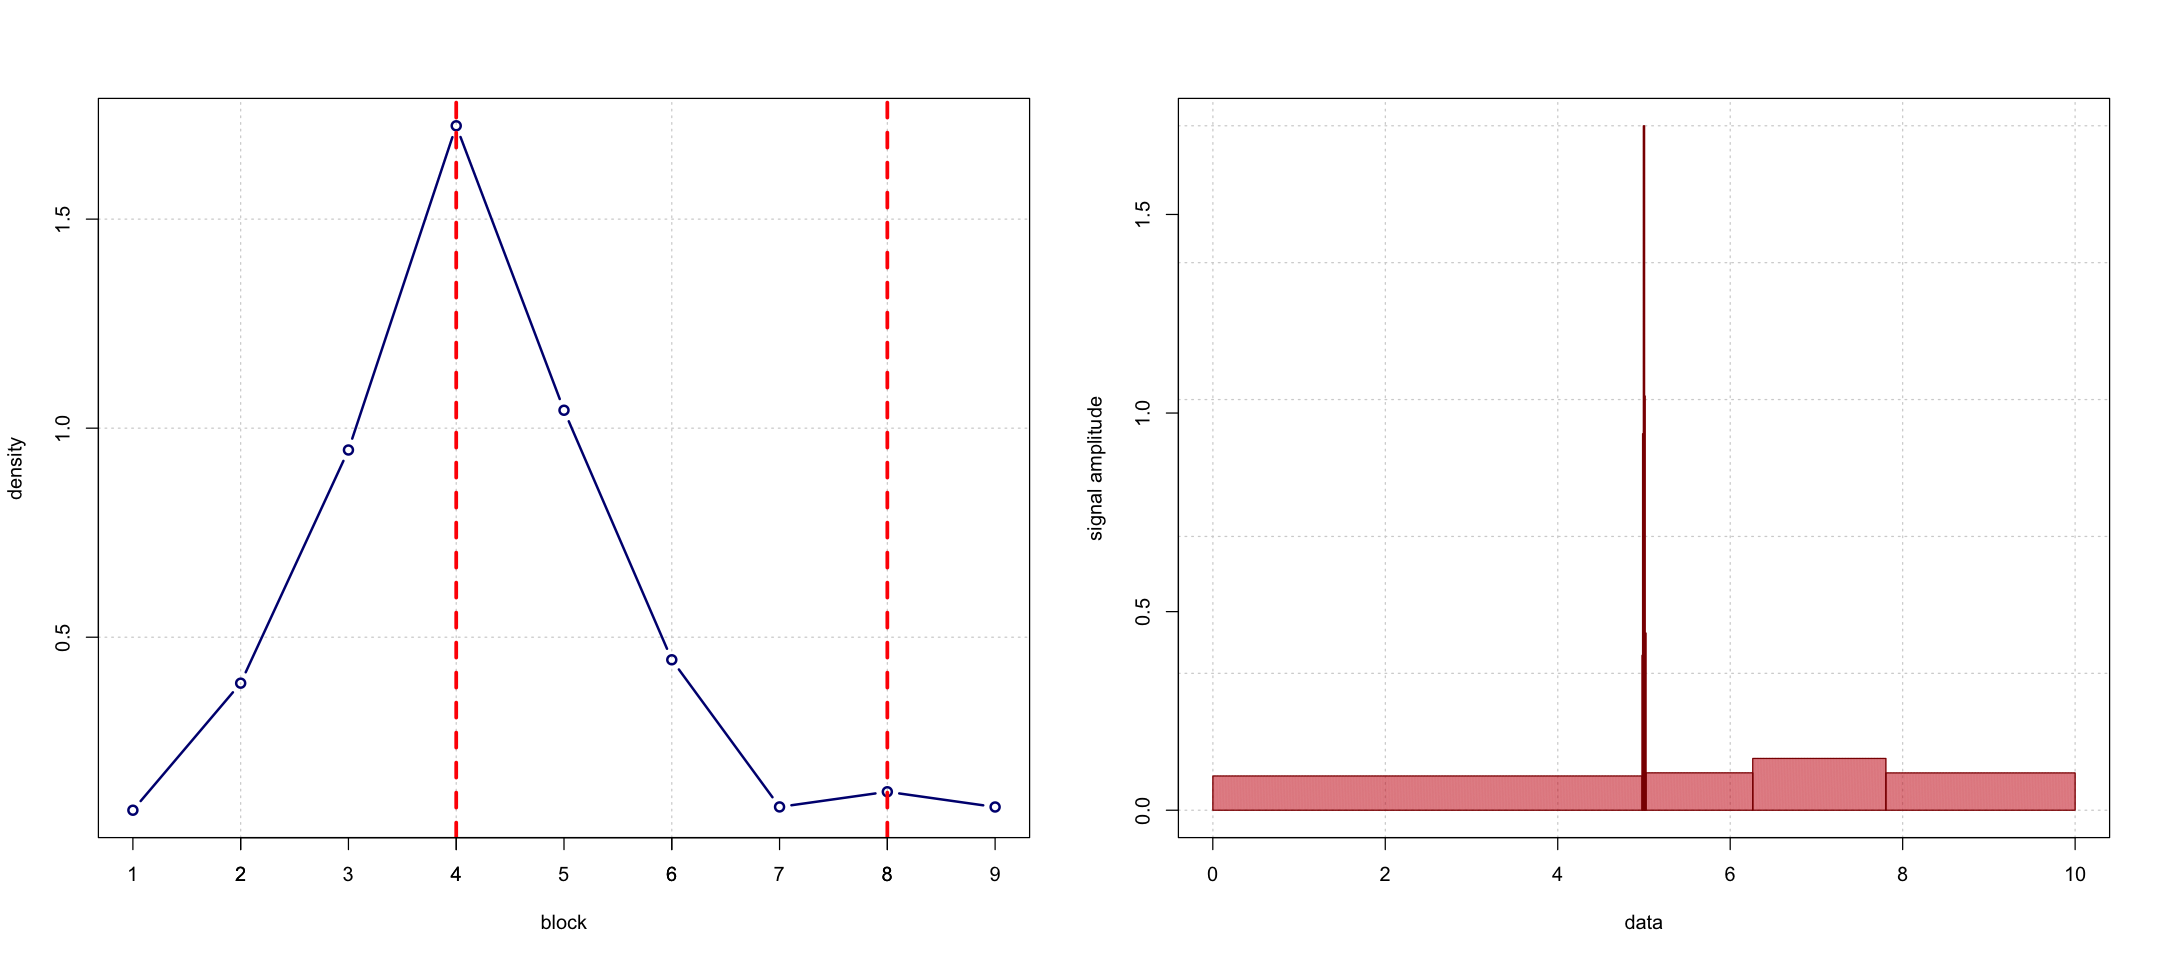

In [7]:
par(mfrow=c(1,2),bg="white")

#--------------------------------------------------------------------
## inspect the block's structure

block<-1:length(h2$mids)
counts<-h2$counts
density<-h2$density
centroid<-h2$mids

df<-data.frame(block,counts,density,centroid)
df

plot(block,density,type='b',col='navy',lwd=2, panel.first=grid())
abline(v=4, lwd=3, col='red', lty='dashed')
abline(v=8, lwd=3, col='red', lty='dashed')
axis(1, at = seq(1, length(h2$mids), by = 1), las=1)


h2<-hist(data,breaks=breaks,density=200, panel.first=grid(),
          freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',main='',ylab='signal amplitude')
box()

Looking at the density graph above, we can easily find the location of the peaks as the centroid of the blocks corresponding to the local maxima.

In [8]:
peak1<-h2$mids[h2$density==density[4]]
peak2<-h2$mids[h2$density==density[8]]

cat('position of the first peak:', peak1,'\n')
cat('position of the second peak:', peak2,'\n')

position of the first peak: 5.000085 
position of the second peak: 7.03342 


### 4.3 Kernel density estimator for SBAM

SBAM (Sparse Bayesian Auxiliary Module) is a Python module for the PySindy package developed by R. Gaudio, L. Giorgetti, E. R. Vero and A. Zanoli as final project for the Computational Physics course of the Master's Degree in Physics of Data at the University of Padua [5][6].

PySINDy is a sparse regression package with several implementations for the Sparse Identification of Nonlinear Dynamical systems (SINDy) [7].

The SBAM module provides a bayesian implementation for the sparsity in the original PySindy package and allows us, through the use of a Gibbs Sampler, to obtain a posterior probability distribution of the coefficients of the candidate functions (features) that will be used to reconstruct the dynamics of the system.

In the SBAM module, the mean was used as the best estimator for such posterior. With the Bayesian Blocks algorithm, we can implement a kernel density estimator in the SBAM module with minimal changes to the original code. In this way, the mode can be easily calculated and used as the best estimator for the posterior distributions.

Here, 1000 toy data are generated in order to simulate one of the feature's distribution of the SBAM module.

Dimension of dataset: 1000

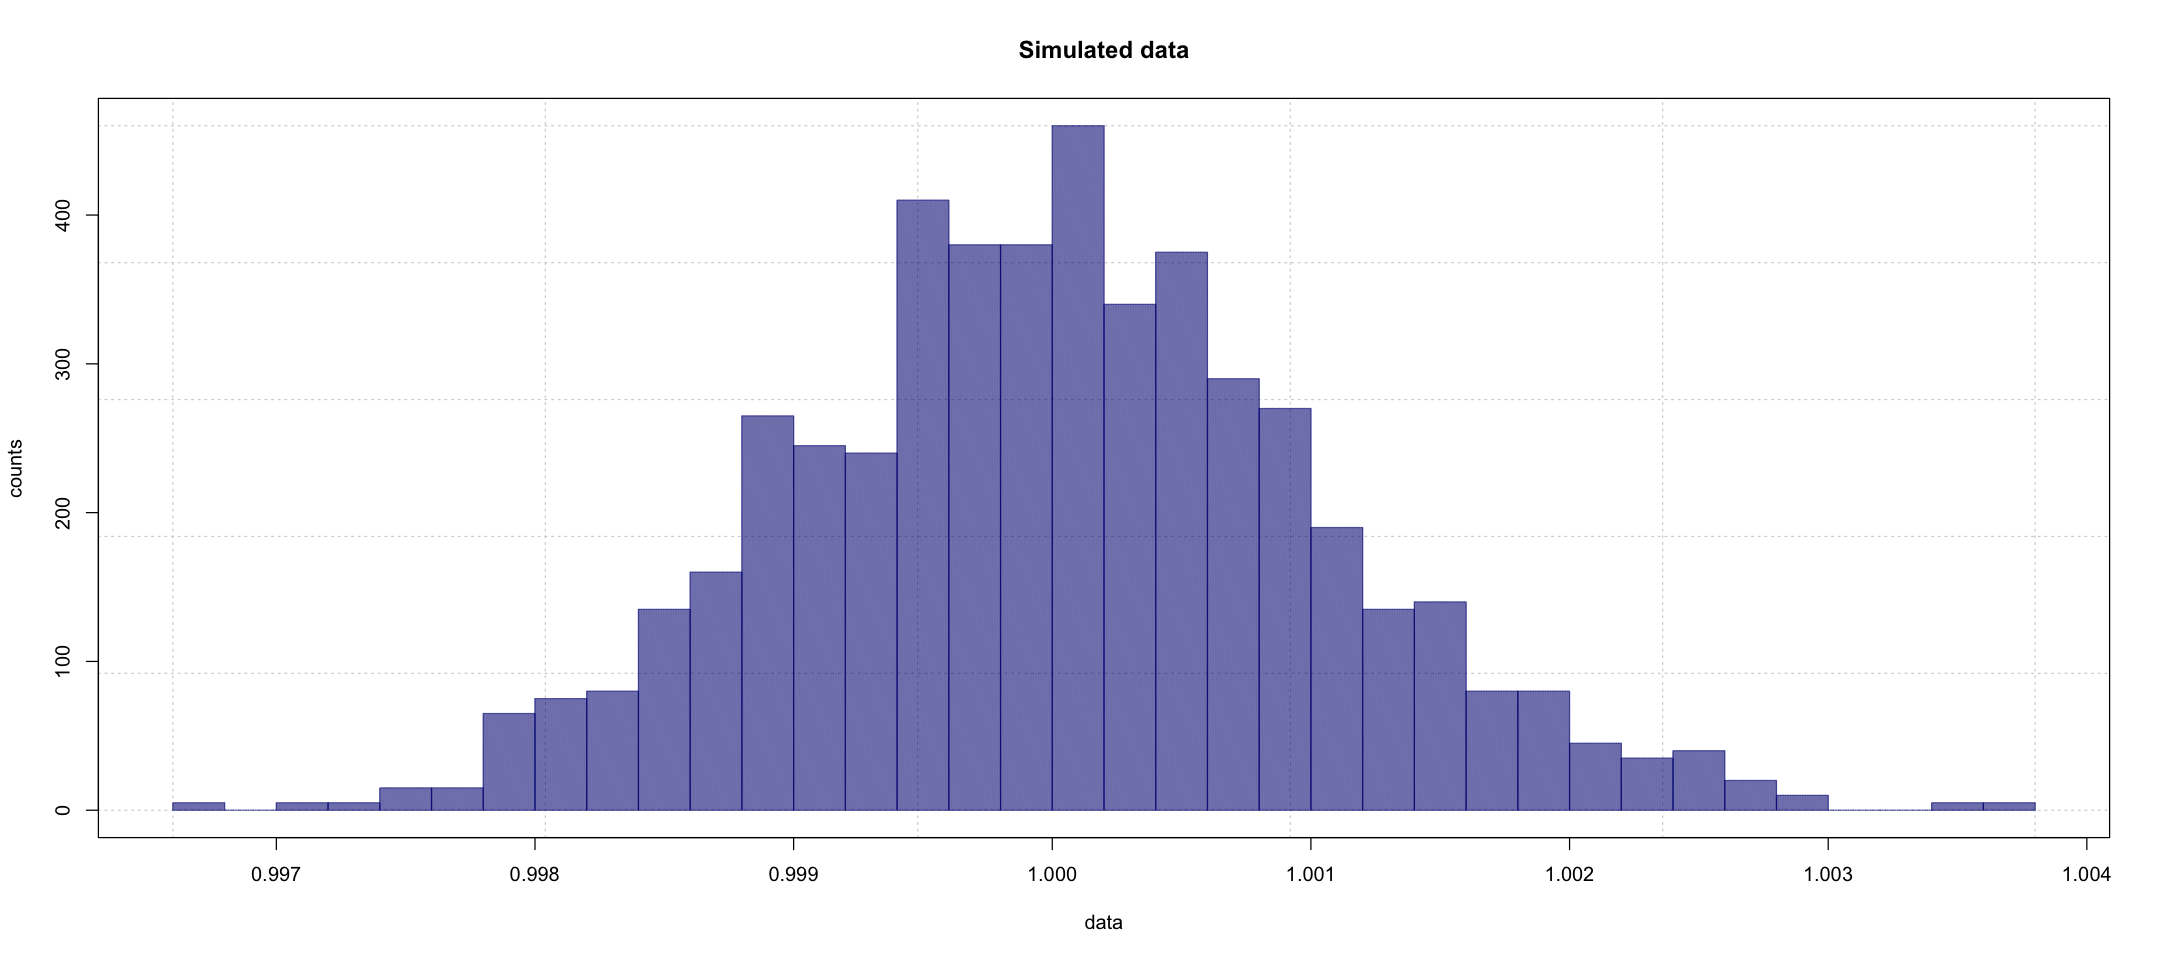

In [9]:
par(bg="white")

data<-rnorm(1000,1,0.001)
N<-length(data)

cat('Dimension of dataset:',N)

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='counts',main='Simulated data')

box()

----------------------------------------------------------------
** Calibrated Prior ** 
p0: 0.01 
Number of blocks: 8 
Computational time: 0.1700029 [s]
----------------------------------------------------------------

mode: 1.000024

block,counts,density,centroid
<int>,<int>,<dbl>,<dbl>
1,10,9.280513,0.9972949
2,54,79.982000,0.9981712
3,201,223.158605,0.9989591
4,483,392.791012,1.0000243
5,137,239.014265,1.0009258
6,80,113.202986,1.0015657
7,31,35.185013,1.0023596
8,4,4.352431,1.0032596


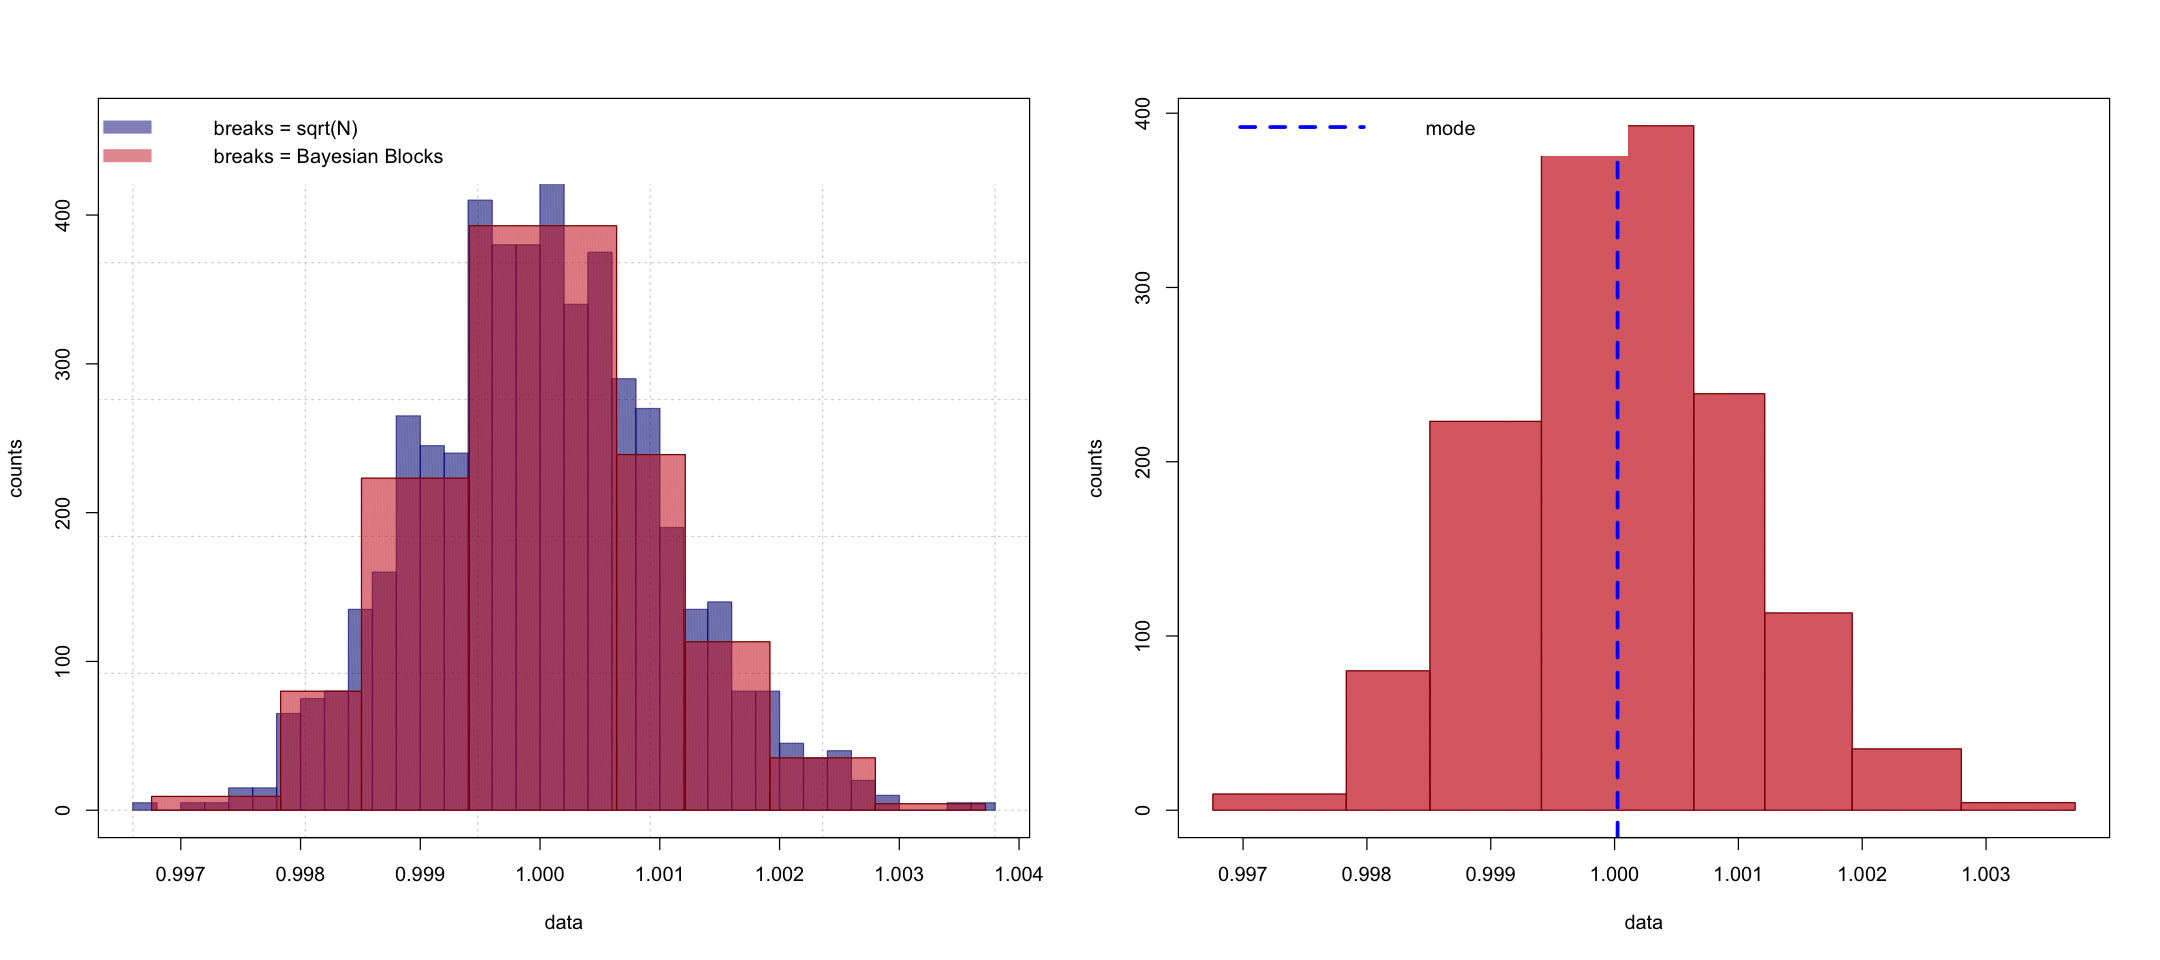

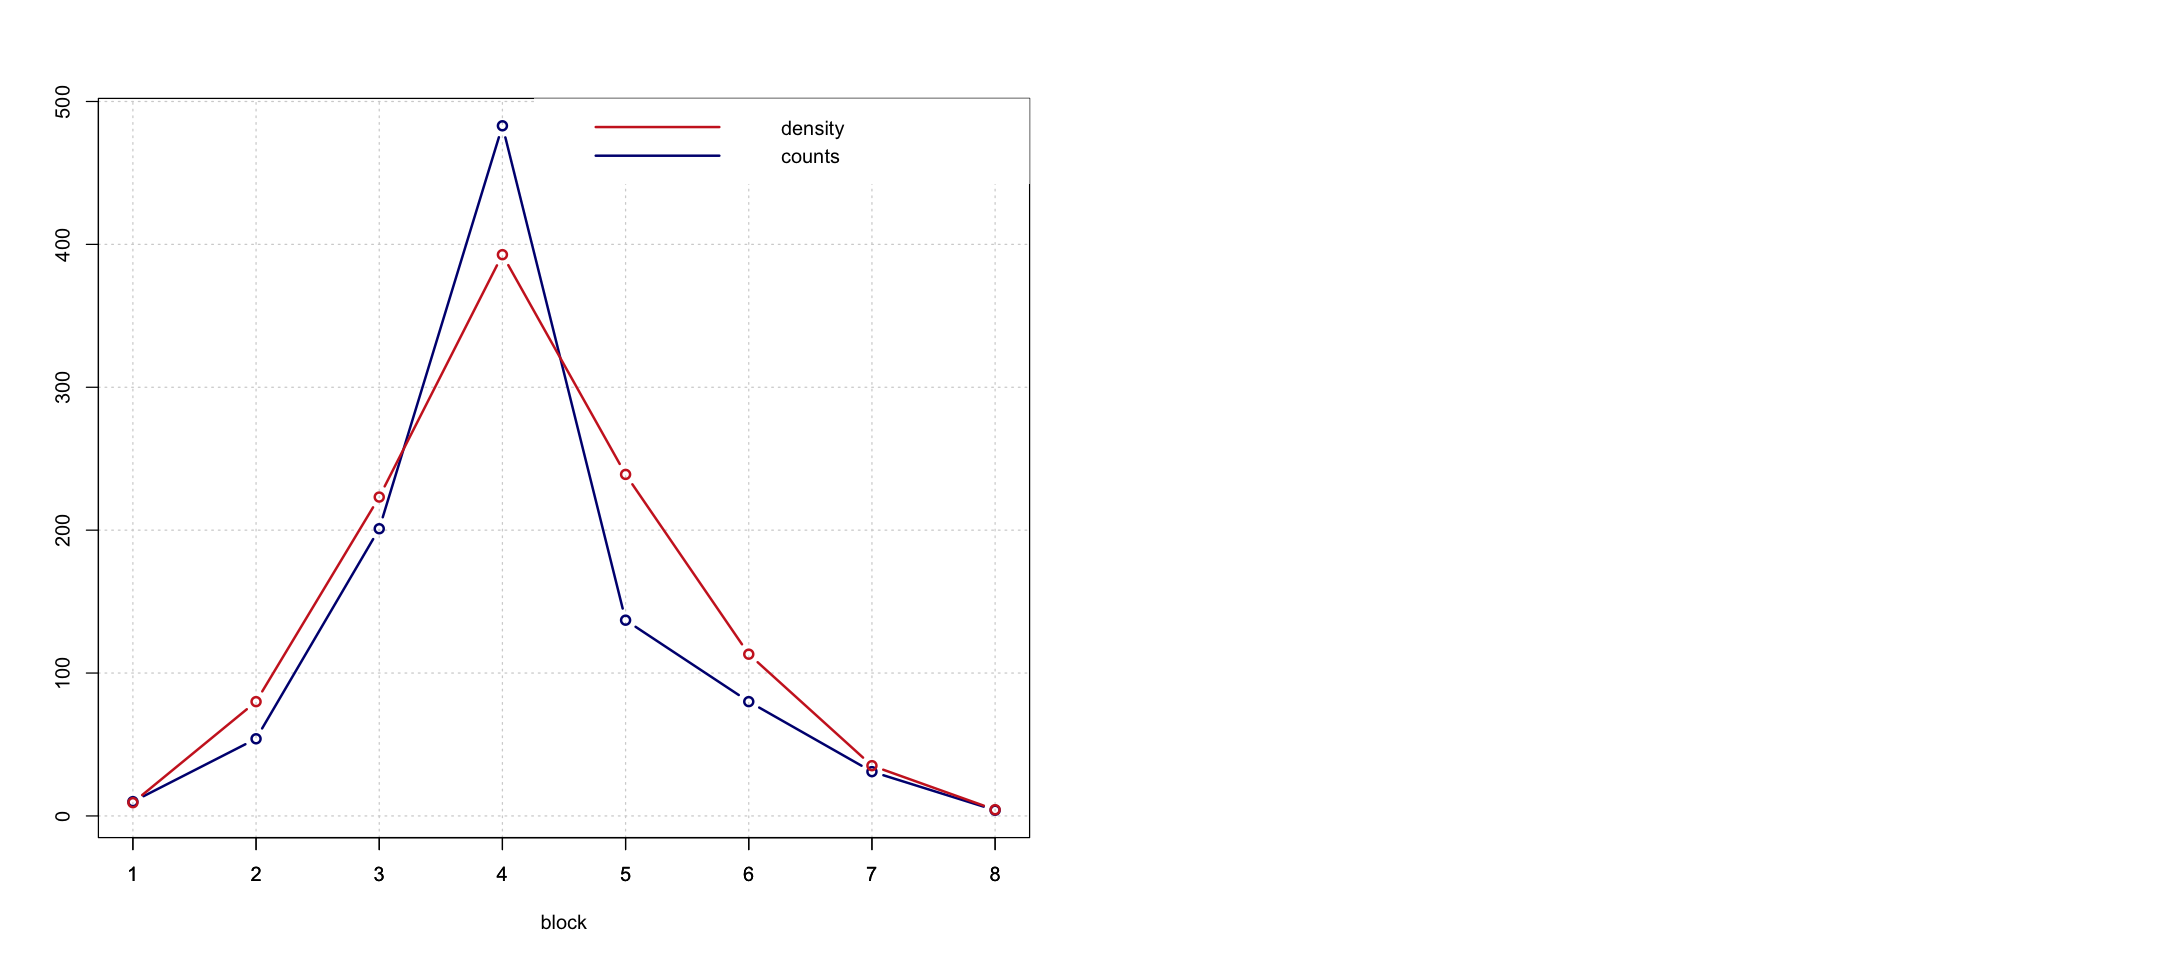

In [10]:
par(mfrow=c(1,2), bg="white")

#--------------------------------------------------------------------
## Calibrated Prior ##

hist(data,breaks=sqrt(N),freq=F,col=scales::alpha('navy',0.5),border=T, panel.first=grid(),density=200,
     xlab='data',ylab='counts',main='')

breaks<-bayesian.blocks(data,prior='p0',p0=0.01,verbose=T)

hist(data,breaks=breaks,density=200,
     freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',add=T)

legend('topright',c('breaks = sqrt(N)','breaks = Bayesian Blocks'), 
       fill=c(scales::alpha('navy',0.5),scales::alpha('firebrick3',0.5)),box.lty=0,border=F) 

box()

#--------------------------------------------------------------------
## get the mode

h<-hist(data,breaks=breaks,density=300,
     freq=F,col=scales::alpha('firebrick3',0.5),border='darkred',main='',ylab='counts')

mode <- h$mids[h$counts == max(h$counts)]
cat('mode:',mode)

abline(v=mode, col='blue',lty='dashed',lwd=3)

legend('topleft',legend='mode',
       col='blue', lwd=3 ,lty='dashed',box.lty=0,border=F) 

box()

#--------------------------------------------------------------------
## inspect the block's structure

block<-1:length(h$mids)
counts<-h$counts
density<-h$density
centroid<-h$mids

df<-data.frame(block,counts,density,centroid)
df


plot(block,counts,type='b',col='navy',lwd=2, panel.first=grid(),ylab='')
lines(block,density,type='b',col='firebrick3',lwd=2)
axis(1, at = seq(1, length(h$mids), by = 1), las=1)
legend('topright',legend=c('density', 'counts'), 
       col=c('firebrick3', 'navy'),lwd=2,box.lty=0,border=F) 

## 5. Conclusions

In conclusion, the Bayesian Blocks algorithm provides an objective way for optimal data segmentation. Futhermore, as shown in this report, the algorithm allows us to produce extremely understandable histograms that highlight the local background structure of the data by imposing as few preconditions as possible. 

The ease of code implementation and the possibility of customization by introducing new priors, make the Bayesian Block algorithm a powerful tool for studying time series, signal detection and, as a kernel density estimator.

---------------------------
### References

[1] Studies in Astronomical Time Series Analysis. VI. Bayesian Block Representations, J. D. Scargle et al., Astrophys. J. 764 (2013) 167

[2] Bayesian Blocks in High Energy Physics: Better Binning made easy! B. Pollack et al. (2017), arXiv:1708.00810

[3] Studies in astronomical time series analysis: 5. Bayesian blocks, a new method to analyze structure in photon counting data, 
   J. D. Scargle, Astrophys. J. 504 (1998) 405

[4] https://gist.github.com/gipert/4d245d97e8f7eebbe7cfc3eddbf27b7b (link to the original Julia code for the algorithm)

[5] https://docs.google.com/presentation/d/13ISUiQMHrTVek67IuxL47fNgRsP5JgQvKNSatCu-L6E/edit#slide=id.p (link to the SBAM presentation)

[6] https://github.com/zanocrate/LCPB_2219/tree/master/project (link to the GitHub repo of the SBAM module)

[7] https://pysindy.readthedocs.io/en/latest/# (link to the PySindy documentation)